# Exercise with Natural Language Processing

For todays exersice we will be doing two things.  The first is to build the same model with the same data that we did in the lecture, the second will be to build a new model with new data. 

## PART 1: 
- 20 Newsgroups Corpus


## PART 2:
- Republican vs Democrat Tweet Classifier

In [1]:
# Import pandas for data handling
import pandas as pd

# NLTK is our Natural-Language-Took-Kit
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Libraries for helping us with strings
import string
# Regular Expression Library
import re

# Import our text vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Import our classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


# Import some ML helper function
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


# Import our metrics to evaluate our model
from sklearn import metrics
from sklearn.metrics import classification_report


# Library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# You may need to download these from nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\Users\Kevin
[nltk_data]     Li\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to C:\Users\Kevin
[nltk_data]     Li\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Kevin
[nltk_data]     Li\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from functools import partial, reduce
from html import escape
from IPython.display import display, display_html
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

def compose(*funcs): # Composes one or more functions into one new function
    return reduce(lambda f, g: lambda x: f(g(x)), funcs)

## Load and display data.
1. Load the 20-newsgroups.csv data into a dataframe.
1. Print the shape
1. Inspect / remove nulls and duplicates
1. Find class balances, print out how many of each topic_category there are.

In [3]:
# 1. Load the 20-newsgroups.csv data into a dataframe.
df = pd.read_csv('data/20-newsgroups.csv')
display(df)

# 2. Print the shape
print(df.shape)

,id,message,topic,topic_category
0,0,From: lerxst@wam.umd.edu (where's my thing)\r\...,7,rec.autos
1,1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,3,From: jgreen@amber (Joe Green)\r\nSubject: Re:...,1,comp.graphics
4,4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
...,...,...,...,...
11309,11309,From: jim.zisfein@factory.com (Jim Zisfein) \r...,13,sci.med
11310,11310,From: ebodin@pearl.tufts.edu\r\nSubject: Scree...,4,comp.sys.mac.hardware
11311,11311,From: westes@netcom.com (Will Estes)\r\nSubjec...,3,comp.sys.ibm.pc.hardware
11312,11312,From: steve@hcrlgw (Steven Collins)\r\nSubject...,1,comp.graphics


(11314, 4)


In [4]:
# 3. Inspect / remove nulls and duplicates
display_html('<strong>Null counts by column:</strong>', raw=True)
display(df.isnull().sum().to_frame('Count').style.format('{:,}'.format))
display_html(f'<strong>Duplicate rows:</strong> {df.duplicated().sum():,}', raw=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

Null counts by column:

,Count
id,0
message,0
topic,0
topic_category,0


Duplicate rows: 0

In [5]:
# 4. Find class balances, print out how many of each topic_category there are.
display_html('<strong>Unique topic categories:</strong>', raw=True)
display(df.topic_category
          .value_counts()
          .to_frame('Count')
          .style.format('{:,}'.format))
display_html(f'<strong>Total unique topic categories: {df.topic_category.nunique():,}</strong>', raw=True)

Unique topic categories:

,Count
rec.sport.hockey,600
soc.religion.christian,599
rec.motorcycles,598
rec.sport.baseball,597
sci.crypt,595
rec.autos,594
sci.med,594
comp.windows.x,593
sci.space,593
comp.os.ms-windows.misc,591


Total unique topic categories: 20

# Text Pre-Processing 
(aka Feature engineering)
1. Make a function that makes all text lowercase.
    * Do a sanity check by feeding in a test sentence into the function. 
    
    
2. Make a function that removes all punctuation. 
    * Do a sanity check by feeding in a test sentence into the function. 
    
    
3. Make a function that removes all stopwords.
    * Do a sanity check by feeding in a test sentence into the function. 
    
    
4. EXTRA CREDIT (This step only): Make a function that stemms all words. 


5. Mandatory: Make a pipeline function that applys all the text processing functions you just built.
    * Do a sanity check by feeding in a test sentence into the pipeline. 
    
    
    
6. Mandatory: Use `df['message_clean'] = df[column].apply(???)` and apply the text pipeline to your text data column. 

In [6]:
# 1. Make a function that makes all text lowercase.
test_string = 'This is A SENTENCE with LOTS OF CAPS.'

str.lower(test_string) # lower is an instance method of the str type which can be used like this.

'this is a sentence with lots of caps.'

In [7]:
# 2. Make a function that removes all punctuation.
strip_punc = partial(re.compile(r'[^\w\s]').sub, ' ')

test_string = 'This is a sentence! 50 With lots of punctuation??? & other #things.'

strip_punc(test_string)

'This is a sentence  50 With lots of punctuation      other  things '

In [8]:
# 3. Make a function that removes all stopwords.
strip_stopwords = compose(' '.join,
                          partial(filter, lambda word: word not in stopwords),
                          word_tokenize)

test_string = 'This is a sentence! With some different stopwords i have added in here.'

strip_stopwords(test_string)

'This sentence ! With different stopwords added .'

In [9]:
# 4. EXTRA CREDIT: Make a function that stemms all words. 
stem_all = compose(' '.join,
                   partial(map, PorterStemmer().stem),
                   word_tokenize)

test_string = 'I played and started playing with players and we all love to play with plays'

stem_all(test_string)

'i play and start play with player and we all love to play with play'

In [10]:
# 5. MANDATORY: Make a pipeline function that applys all the text processing functions you just built.
process_text = compose(' '.join, # More efficient to rewrite stem_all and strip_stopwords together
                       partial(map, PorterStemmer().stem),
                       partial(filter, lambda word: word not in stopwords),
                       word_tokenize, # word_tokenize once instead of twice through the separate functions
                       strip_punc,
                       str.lower)

test_string = 'I played and started playing with players and we all love to play with plays'

process_text(test_string)

'play start play player love play play'

In [11]:
# 6. Mandatory: Use `df[column].apply(???)` and apply the text pipeline to your text data column. 
df['message_clean'] = df.message.apply(process_text)

df[['message', 'message_clean']]

,message,message_clean
0,From: lerxst@wam.umd.edu (where's my thing)\r\...,lerxst wam umd edu thing subject car nntp post...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,guykuo carson u washington edu guy kuo subject...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,twilli ec ecn purdu edu thoma e willi subject ...
3,From: jgreen@amber (Joe Green)\r\nSubject: Re:...,jgreen amber joe green subject weitek p9000 or...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,jcm head cfa harvard edu jonathan mcdowel subj...
...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \r...,jim zisfein factori com jim zisfein subject mi...
11310,From: ebodin@pearl.tufts.edu\r\nSubject: Scree...,ebodin pearl tuft edu subject screen death mac...
11311,From: westes@netcom.com (Will Estes)\r\nSubjec...,west netcom com est subject mount cpu cooler v...
11312,From: steve@hcrlgw (Steven Collins)\r\nSubject...,steve hcrlgw steven collin subject sphere 4 po...


# Text Vectorization

1. Define your `X` and `y` data. 


2. Initialize a vectorizer (you can use TFIDF or BOW, it is your choice).
    * Do you want to use n-grams..?


3. Fit your vectorizer using your X data.
    * Remember, this process happens IN PLACE.


4. Transform your X data using your fitted vectorizer. 
    * `X = vectorizer.???`



5. Print the shape of your X.  How many features (aka columns) do you have?

In [12]:
# 1. Define your `X` and `y` data. 
X = df['message_clean'].values
y = df['topic_category'].values

In [13]:
# 2. Initialize a vectorizer (you can use TFIDF or BOW, it is your choice).
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

In [14]:
# 3. Fit your vectorizer using your X data
vectorizer.fit(X);

In [15]:
# 4. Transform your X data using your fitted vectorizer.
X = vectorizer.transform(X)

In [16]:
# 5. Print the shape of your X.  How many features (aka columns) do you have?
print(X.shape)

(11314, 1133431)


# Split your data into Training and Testing data. 

In [17]:
# Split our data into testing and training like always. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

___
# Build and Train Model
Use Multinomial Naive Bayes to classify these documents. 

1. Initalize an empty model. 
2. Fit the model with our training data.


Experiment with different alphas.  Use the alpha gives you the best result.

EXTRA CREDIT:  Use grid search to programmatically do this for you. 

In [18]:
def find_best_parameters(X_train, y_train, **params):
    gsc = GridSearchCV(estimator=MultinomialNB(),
                       param_grid=params,
                       scoring='accuracy')
    gsc.fit(X_train, y_train)
    return gsc.best_params_

params = find_best_parameters(X_train, y_train,
                              alpha=[0.01, 0.10, 1.00],
                              fit_prior=[True, False])

pd.DataFrame.from_dict(params, orient='index', columns=['Value'])

,Value
alpha,0.01
fit_prior,False


In [19]:
# 1. Initalize an empty model. 
model = MultinomialNB(**params)

In [20]:
# Fit our model with our training data.
model.fit(X_train, y_train);

# Evaluate the model.

1. Make new predicitions using our test data. 
2. Print the accuracy of the model. 
3. Print the confusion matrix of our predictions. 
4. Using `classification_report` print the evaluation results for all the classes. 



In [21]:
# 1. Make new predictions of our testing data. 
y_pred = model.predict(X_test)

In [22]:
# 2. Print the accuracy of the model.
display_html(f'<strong>Model Accuracy:</strong> {model.score(X_test, y_test):.2}', raw=True)

Model Accuracy: 0.9

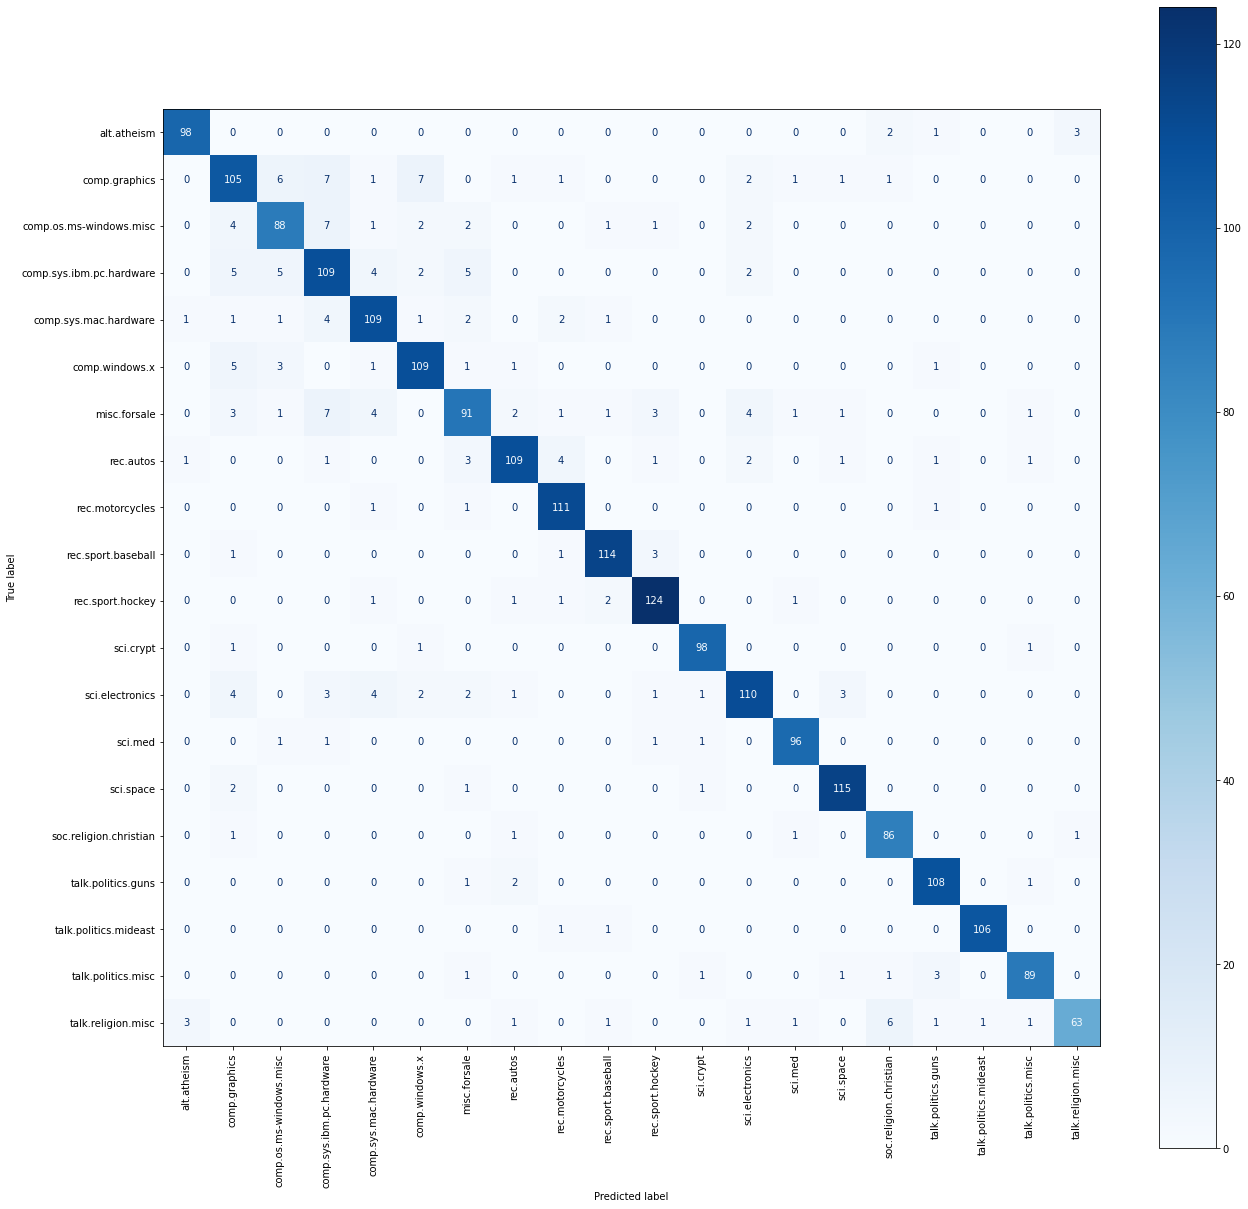

In [23]:
# 3. Plot the confusion matrix of our predictions
fig, ax = plt.subplots(figsize=(21, 21))
disp = plot_confusion_matrix(model,
                             X_test,
                             y_test,
                             display_labels=model.classes_,
                             cmap=plt.cm.Blues,
                             ax=ax)
plt.xticks(rotation=90);

In [24]:
# 4. Using `classification_report` print the evaluation results for all the classes. 
print(classification_report(y_test,
                            model.predict(X_test),
                            target_names=model.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.95      0.94      0.95       104
           comp.graphics       0.80      0.79      0.79       133
 comp.os.ms-windows.misc       0.84      0.81      0.83       108
comp.sys.ibm.pc.hardware       0.78      0.83      0.80       132
   comp.sys.mac.hardware       0.87      0.89      0.88       122
          comp.windows.x       0.88      0.90      0.89       121
            misc.forsale       0.83      0.76      0.79       120
               rec.autos       0.92      0.88      0.90       124
         rec.motorcycles       0.91      0.97      0.94       114
      rec.sport.baseball       0.94      0.96      0.95       119
        rec.sport.hockey       0.93      0.95      0.94       130
               sci.crypt       0.96      0.97      0.97       101
         sci.electronics       0.89      0.84      0.87       131
                 sci.med       0.95      0.96      0.96       100
         

# Manual predicition
Write a new sentence that you think will be classified as talk.politics.guns. 
1. Apply the text pipeline to your sentence
2. Transform your cleaned text using the `X = vectorizer.transform([your_text])`
    * Note, the `transform` function accepts a list and not a individual string.
3. Use the model to predict your new `X`. 
4. Print the prediction

In [25]:
my_sentence = 'They are using fake school shootings to take away our guns and our second amendment! ' \
            + 'Even if the shootings were real, the answer is for everyone to have more guns. ' \
            + 'Don’t forget to donate to the National Rifle Association (NRA). America! 🇺🇸'
display_html(escape(my_sentence), raw=True)

# 1. Apply the text pipeline to your sentence
cleaned_sentence = process_text(my_sentence)

# 2. Transform your cleaned text using the `X = vectorizer.transform([your_text])`\
X = vectorizer.transform([cleaned_sentence])

# 3. Use the model to predict your new `X`. 
display_html(f'<strong>Prediction:</strong> {model.predict(X)[0]}', raw=True)

# 4. Print the prediction
pd.DataFrame(model.predict_proba(X)[0],
             index=model.classes_,
             columns=['Probability']) \
  .sort_values(by='Probability', ascending=False) \
  .style.format('{:.2%}'.format)

They are using fake school shootings to take away our guns and our second amendment! Even if the shootings were real, the answer is for everyone to have more guns. Don’t forget to donate to the National Rifle Association (NRA). America! 🇺🇸

Prediction: talk.politics.guns

,Probability
talk.politics.guns,98.64%
sci.crypt,0.85%
talk.politics.mideast,0.14%
talk.religion.misc,0.07%
alt.atheism,0.05%
talk.politics.misc,0.04%
rec.sport.hockey,0.04%
rec.autos,0.04%
rec.motorcycles,0.03%
sci.space,0.02%


___
# PART 2: Twitter Data
This part of the exercise is un-guided on purpose.  

Using the `dem-vs-rep-tweets.csv` build a classifier to determine if a tweet was written by a democrat or republican. 

Can you get an f1-score higher than %82

Because tweets are so small already, try not removing stopwords....

In [26]:
# 1. Load the dem-vs-rep-tweets data into a dataframe.
# 2. Print the shape
df = pd.read_csv('data/dem-vs-rep-tweets.csv')

df

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...
...,...,...,...
86455,Republican,RepTomPrice,Check out my op-ed on need for End Executive O...
86456,Republican,RepTomPrice,"Yesterday, Betty &amp; I had a great time lear..."
86457,Republican,RepTomPrice,We are forever grateful for the service and sa...
86458,Republican,RepTomPrice,Happy first day of school @CobbSchools! #CobbB...


In [27]:
display_html('<strong>Null counts by column:</strong>', raw=True)
display(df.isnull().sum().to_frame('Count').style.format('{:,}'.format))
display_html(f'<strong>Duplicate rows:</strong> {df.duplicated().sum():,}', raw=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

Null counts by column:

,Count
Party,0
Handle,0
Tweet,0


Duplicate rows: 57

In [28]:
display_html('<strong>Unique parties:</strong>', raw=True)
df.Party \
  .value_counts() \
  .to_frame('Count') \
  .style.format('{:,}'.format)

Unique parties:

,Count
Republican,"44,362"
Democrat,"42,041"


In [29]:
# Preprocess, vectorize, and split data.
X = CountVectorizer(preprocessor=compose(stem_all, strip_punc, str.lower), ngram_range=(1, 2)).fit_transform(df.Tweet)
y = df.Party
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Find the best parameters for MultinomialNB.
params = find_best_parameters(X_train, y_train,
                              alpha=[0.01, 0.10, 1.00],
                              fit_prior=[True, False])

# Train the model with the best parameters and show a summary report of its precision, recall, and F1 scores.
model = MultinomialNB(**params).fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test), target_names=model.classes_))

              precision    recall  f1-score   support

    Democrat       0.83      0.80      0.82      8460
  Republican       0.82      0.84      0.83      8821

    accuracy                           0.82     17281
   macro avg       0.82      0.82      0.82     17281
weighted avg       0.82      0.82      0.82     17281

